# Data Cleaning and Preparation

Our first goal is to explore the data obtained from IMDB and WIkipedia and see that they data is consistent and clean. We will then do some poreliminarfy analysis a out the various trends in predicting movie success b ased on revenues, IMDB votes and Academyy Award wins and nominations

In [1]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
%matplotlib inline

## Data Cleaning

THe acvquired data have been collected in the following data-structres and names: <br>
**Oscar categories and movie genres** THe hand-selected standard categories for the Acaemy Awards and the movie-genres are stored in the two followiong files. 
1. genre_dict = pickle.load(open("my_data_2/genre_dict","rb"))
2. main_categories_list = pickle.load(open("my_data_2/main_categories_list","rb")) 

The following dataframes have also been created:
1. df_oscars_films: DataFrame of films with wins('W'),nominations('N') or nothing('O') froim 1960 to 2019 oscars (films from 1959 to 2018)
2. df_oscars_individual: DataFRame of invidiaul categories (direcvtorsm, actors, supporting actrors, music, editing, etc)
3. df_imdb: Dataframe of movies scraped from IMDB.com (:pages1,2,3) and Wikpedia cointaining imdbID, votes, ratings, budget, box_office, running_time and cast_size
4. movie_info_dict: Dictionary of movie information for all the films in the above data frames combined

In [12]:
# Get preselected oscars info: Genres (genre_dict) and main oscar categories (main_categories)
genre_dict = pickle.load(open("my_data_3/genre_dict","rb"))
main_categories = pickle.load(open("my_data_3/main_categories","rb")) 
print(main_categories)

df_oscars = pd.read_csv('my_data_3/df_oscars_films.csv', index_col=[0])
df_oscars = df_oscars.rename(columns = {'index':'film'})
df_oscars.film = df_oscars.film.str.lower()

df_individual = pd.read_csv('my_data_3/df_oscars_individual.csv', index_col=[0])
df_movies = pd.read_csv('my_data_3/df_movies.csv', index_col=[0])
df_movies = df_movies[(df_movies.budget<500)&(df_movies.box_office < 5000)&(df_movies.n_votes > 1000)]


movie_dict = pickle.load(open("my_data_3/movie_info_dict","rb"))

['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay', 'music', 'cinematography', 'editing', 'effects', 'sound', 'costume', 'song', 'art_direction']


In [13]:
# print(df_oscars.head())
# print(df_individual.head())
df_individual.tail(2317).head(10)

,index,year,name,category,result
4647,10,1992,Anthony Hopkins,actor,W
4648,11,1992,Warren Beatty,actor,N
4649,12,1992,Robert De Niro,actor,N
4650,13,1992,Nick Nolte,actor,N
4651,14,1992,Robin Williams,actor,N
4652,15,1992,Jodie Foster,actress,W
4653,16,1992,Geena Davis,actress,N
4654,17,1992,Laura Dern,actress,N
4655,18,1992,Bette Midler,actress,N
4656,19,1992,Susan Sarandon,actress,N


In [460]:
len(movie_dict)
movie_dict['moneyball']
# movie_dict['a beautiful day in the neighborhood']

{'director': ['Bennett Miller'],
 'genre': None,
 'producer': ['Michael De Luca', 'Rachael Horovitz', 'Brad Pitt'],
 'screenplay': ['Steven Zaillian', 'Aaron Sorkin'],
 'book': 'yes',
 'cast': ['Brad Pitt',
  'Jonah Hill',
  'Philip Seymour Hoffman',
  'Robin Wright',
  'Chris Pratt',
  'Stephen Bishop',
  'Reed Diamond',
  'Brent Jennings',
  'Tammy Blanchard',
  'Jack McGee',
  'Vyto Ruginis',
  'Nick Searcy'],
 'music': ['Mychael Danna'],
 'cinematography': ['Wally Pfister'],
 'edit': ['Christopher Tellefsen'],
 'year': 2011,
 'running_time': 133,
 'language': ['English'],
 'budget': 50.0,
 'box_office': 110.2,
 'imdbID': 'tt1210166',
 'imdb_rating': 7.6,
 'n_votes': 335577,
 'title': 'moneyball'}

## Final Datastructures and functions

Ultimately, what do we want? We wants all oscar nominate movies from 1960 to 2018. We also want a list of the most popular/well-known and critically aclaimed movies from 1960 to 2018, which will ideally contain AL oscar nomiunatred movies aloing with the movie information (Wikipedia infobox). We want a data-frame of these movies with the proper information in the correct format (budget and box_office as floats, genre as a list etc.)

Scores:

We will also have a separate dataframe for thge 2019 movies which will be exactly as the other movies, except that they will have no post-oscar_score

In [465]:
# Manually fixing some outliers
# df_movies.loc[3807,'budget']=35.0
# df_movies.loc[4705,'budget']=11.0
# df_movies.loc[3807,'box_office']=13.75
# df_movies.loc[1,'box_office']=11.31
# df_movies.to_csv('my_data_3/df_movies.csv')

In [15]:
movie_dict['cleopatra',1963]

{'director': ['Joseph L. Mankiewicz'],
 'genre': ['his', 'epi', 'dra'],
 'producer': ['Walter Wanger'],
 'screenplay': ['Joseph L. Mankiewicz', 'Ranald MacDougall', 'Sidney Buchman'],
 'book': 'yes',
 'cast': ['Elizabeth Taylor',
  'Richard Burton',
  'Rex Harrison',
  'Roddy McDowall',
  'Martin Landau',
  'Hume Cronyn',
  'George Cole'],
 'music': ['Alex North'],
 'cinematography': ['Leon Shamroy'],
 'edit': ['Dorothy Spencer'],
 'year': 1963,
 'running_time': 248,
 'language': ['English'],
 'budget': 31.1,
 'box_office': 57.8,
 'imdbID': 'tt0056937',
 'imdb_rating': 7.0,
 'n_votes': 27059,
 'title': 'cleopatra'}

# Data Exploration and Feature Engineering

We will work with the following dataframes:
1. df_oscars_films
2. df_oscars_individuals
3. df_movies

From these, we will derive the following dataframes:
1. df_movies_wins_and_noms
2. df_ind_wins_and_noms

## Movies Wins and Nominations

First w enote that there are ~40 oscar nomiated movies that are not included in the movie dictionary (movie_dict)

In [17]:
oscars_set = set(df_oscars.query("year > 1960").film)
print(f'Total oscar nominated movie atre 1960: {len(oscars_set)}')
movies_set = set(df_movies.title)
print(f'Total movie in the list: {len(movies_set)}')
oscars_minus_imdb = list(oscars_set - movies_set)
print(f'Oscar nominated movies missing: {len(oscars_minus_imdb)}')
print(f'Unique movies in oscars list: {len(df_oscars.index.unique())}')


Total oscar nominated movie atre 1960: 1657
Total movie in the list: 4733
Oscar nominated movies missing: 446
Unique movies in oscars list: 2058


In [482]:
df_oscars.head()

,film,actor,actress,art_direction,cinematography,costume,director,editing,effects,music,picture,s_actor,s_actress,screenplay,song,sound,year
0,all the king's men,W,O,O,O,O,N,N,O,O,W,N,W,N,O,O,1949
1,battleground,O,O,O,W,O,N,N,O,O,N,N,O,O,O,O,1949
2,the heiress,O,W,W,N,W,N,O,O,W,N,N,O,O,O,O,1949
3,a letter to three wives,O,O,O,O,O,W,O,O,O,N,O,O,W,O,O,1949
4,twelve o'clock high,N,O,O,O,O,O,O,O,O,N,W,O,O,O,W,1949


In [18]:
## Number of wins and nomination for films
df_movies_wins_and_noms = pd.DataFrame()
cols = ['film','picture', 'director', 'actor', 'actress', 's_actor',
       's_actress', 'cinematography', 'screenplay', 'editing', 'costume',
       'effects', 'music', 'sound', 'art_direction', 'song']
# for row in df_oscars.iterrows():
#     df_movies_wins_and_noms = df_movies_wins_and_noms.append(row[1][cols].value_counts()).fillna(0)

df_oscars_long = pd.melt(df_oscars, id_vars = ['film', 'year'], var_name='category', value_name = 'result')
print(df_oscars_long.head())
df_oscars_long.query('year == 1963').query('result == "W"')



                      film  year category result
0       all the king's men  1949    actor      W
1             battleground  1949    actor      O
2              the heiress  1949    actor      O
3  a letter to three wives  1949    actor      O
4      twelve o'clock high  1949    actor      N


,film,year,category,result
461,lilies of the field,1963,actor,W
2522,hud,1963,actress,W
4574,america america,1963,art_direction,W
4575,cleopatra,1963,art_direction,W
6633,cleopatra,1963,cinematography,W
6638,hud,1963,cinematography,W
8691,cleopatra,1963,costume,W
8694,8½,1963,costume,W
10747,tom jones,1963,director,W
12808,how the west was won,1963,editing,W


## Most awarded genres

In [20]:
df_picture_wins = df_oscars[df_oscars.picture =='W']
df_picture_noms = df_oscars[df_oscars.picture !='O']
df_picture_wins.head()

,film,actor,actress,art_direction,cinematography,costume,director,editing,effects,music,picture,s_actor,s_actress,screenplay,song,sound,year
0,all the king's men,W,O,O,O,O,N,N,O,O,W,N,W,N,O,O,1949
34,all about eve,O,N,N,N,W,W,N,O,N,W,W,N,W,O,W,1950
67,an american in paris,O,O,W,W,W,N,N,O,W,W,O,O,O,O,O,1951
103,the greatest show on earth,O,O,O,O,N,N,N,O,O,W,O,O,O,O,O,1952
139,from here to eternity,N,N,O,W,N,W,W,O,N,W,W,W,W,O,W,1953


Counter({'dra': 40, 'com': 14, 'epi': 13, 'his': 10, 'bio': 9, 'rom': 8, 'mus': 5, 'war': 5, 'cri': 5, 'adv': 2, 'psy': 2, 'thr': 2, 'fan': 2, 'mys': 1, 'oth': 1, 'dis': 1})


Counter({'dra': 195, 'com': 66, 'bio': 48, 'rom': 41, 'epi': 35, 'his': 28, 'war': 22, 'cri': 22, 'thr': 21, 'mus': 19, 'oth': 13, 'fan': 13, 'psy': 9, 'adv': 9, 'sci': 7, 'mys': 6, 'act': 5, 'hor': 4, 'pol': 4, 'dis': 3, 'ani': 2, 'other': 1, 'sup': 1})


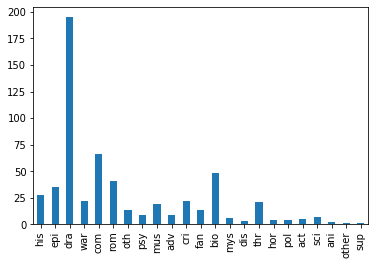

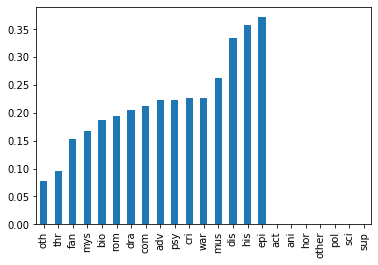

In [48]:
# The genres of winning movies
df_oscars.head()
df_picture_wins = df_oscars[df_oscars.picture =='W']
df_picture_noms = df_oscars[df_oscars.picture !='O']

win_genres = []
for title,year in zip(df_picture_wins.film,df_picture_wins.year):
    if (title,year) in movie_dict:
        movie = movie_dict[title,year]
    else:
        continue
    if 'genre' in movie and movie['genre']!=None:
        win_genres = win_genres + movie['genre']

nom_genres = []
for title,year in zip(df_picture_noms.film,df_picture_noms.year):
    if (title,year) in movie_dict:
        movie = movie_dict[title,year]
    else:
        continue
    if 'genre' in movie and movie['genre']!=None:
        nom_genres = nom_genres + movie['genre']

win_genre = collections.Counter(win_genres)  
nom_genre = collections.Counter(nom_genres)  
# df_picture_wins.head()

print(win_genre)
print('\n')
print(nom_genre)

# pd.Series(win_genre).plot(kind='bar')
pd.Series(nom_genre).plot(kind='bar')
x = pd.Series(win_genre)/pd.Series(nom_genre)
plt.figure()
x.sort_values().plot(kind='bar')

# print('winning genre')
# pd.Series(dict(win_genre)).plot.bar()
# plt.figure()
# print('nominated genre')
# pd.Series(dict(nom_genre)).plot.bar()



## Individual Wins and Nominations

In [49]:
print(f'Total number of individual winners in all categories combined: {len(set(df_individual.name))}')
most_noms = df_individual.name.value_counts()
most_wins = df_individual[df_individual.result=='N'].name.value_counts()
most_wins.head()

Total number of individual winners in all categories combined: 3378


John Williams      42
Alfred Newman      31
Edith Head         26
Hal Pereira        22
Lyle R. Wheeler    22
Name: name, dtype: int64

In [51]:
df_individual[df_individual.name == 'Steven Spielberg']

,index,year,name,category,result
3529,6,1978,Steven Spielberg,director,N
3843,9,1982,Steven Spielberg,director,N
3912,1,1983,Steven Spielberg,picture,N
3918,7,1983,Steven Spielberg,director,N
4161,1,1986,Steven Spielberg,picture,N
4799,0,1994,Steven Spielberg,picture,W
4804,5,1994,Steven Spielberg,director,W
5221,3,1999,Steven Spielberg,picture,N
5223,5,1999,Steven Spielberg,director,W
5798,9,2006,Steven Spielberg,director,N


# Scoring films and individuals

In order to obtain a score for each film, we use the following function to give scores to winners and nominees based on the level of compeition foir each year and category. If a given year (1977) and category (Best Actor) has N nominees and 1 winner, then each winner gets 1 points and each nominee gets (1/N) points. This ensures that higher compeition yields higher points, but more nominations yield lower share. 

In [52]:
def oscar_score(df_long,categories,years):
    """
    This returns an oscar score for each year and fategory, 
    both for films and individuals, based competition.
    """
    
    # add the score column
    scores = []
    df = pd.DataFrame()

    
    if categories == 'all':
        categories = pickle.load(open("my_data_3/main_categories","rb"))
    for year in years:
        if year%10==0:
            print('In year:', year)
        for category in categories:
            # Only get winners and nominees for the year and category
            df_this = df_long[(df_long.year ==year) & (df_long.category==category)]
            if len(df_this)==0:
                print(f'Category {category} for {year} not avaialable')
                continue

            # Calculate score
            score = dict()
            n_wins = len(df_this[df_this.result=='W'])+len(df_this[df_this.result=='WN'])
            n_noms = len(df_this[df_this.result!='O'])
            
            if n_wins==0 or n_noms==0:
                print(f'No winner or nomination in {year} for category {category}')
                continue
            score['W']= min(6,n_noms/n_wins) # winner gets n points, more the competition, higher the point
            score['WN']= n_noms/n_wins
            score['N']= 1/n_noms # nominees share, more the nominees , less each one gets 
            score['O']= 0 # else zero points (not needed, shown for consistency)
            scores = [score[x] for x in df_this.result]
            df_this['score']=scores
            scores = []
            df = df.append(df_this)

            
    
    return df
    
  

In [53]:
df_oscars_long.head()

,film,year,category,result
0,all the king's men,1949,actor,W
1,battleground,1949,actor,O
2,the heiress,1949,actor,O
3,a letter to three wives,1949,actor,O
4,twelve o'clock high,1949,actor,N


In [54]:
categories = 'all'
df_oscar_score = oscar_score(df_oscars_long,categories,range(1950,2019))
df_oscar_score.head()


In year: 1950
No winner or nomination in 1951 for category effects


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No winner or nomination in 1952 for category effects
No winner or nomination in 1953 for category effects
In year: 1960
In year: 1970
No winner or nomination in 1972 for category effects
No winner or nomination in 1973 for category effects
No winner or nomination in 1974 for category effects
No winner or nomination in 1975 for category effects
No winner or nomination in 1976 for category effects
No winner or nomination in 1978 for category effects
In year: 1980
No winner or nomination in 1980 for category effects
No winner or nomination in 1983 for category effects
In year: 1990
No winner or nomination in 1990 for category effects
In year: 2000
In year: 2010
No winner or nomination in 2012 for category art_direction
No winner or nomination in 2013 for category art_direction
No winner or nomination in 2014 for category art_direction
No winner or nomination in 2015 for category art_direction
No winner or nomination in 2016 for category art_direction
No winner or nomination in 2017 for ca

,film,year,category,result,score
18556,all about eve,1950,picture,W,5.0
18557,born yesterday,1950,picture,N,0.2
18558,father of the bride,1950,picture,N,0.2
18559,king solomon's mines,1950,picture,N,0.2
18560,sunset boulevard,1950,picture,N,0.2


In [55]:
print(df_individual.category.unique())
df_individual.head()

['picture' 'director' 'actor' 'actress' 's_actor' 's_actress' 'screenplay'
 'music' 'song' 'sound' 'art_direction' 'cinematography' 'editing'
 'effects' 'costume']


,index,year,name,category,result
0,0,1940,David O. Selznick,picture,W
1,1,1940,David Lewis,picture,N
2,2,1940,Victor Saville,picture,N
3,3,1940,Leo McCarey,picture,N
4,4,1940,Frank Capra,picture,N


In [56]:
categories = pickle.load(open("my_data_3/main_categories","rb"))
# categories = ['director', 's_actress']
print(categories)

print(df_individual.category.unique())
df_indi_score = oscar_score(df_individual,categories,range(1940,2019))


['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay', 'music', 'cinematography', 'editing', 'effects', 'sound', 'costume', 'song', 'art_direction']
['picture' 'director' 'actor' 'actress' 's_actor' 's_actress' 'screenplay'
 'music' 'song' 'sound' 'art_direction' 'cinematography' 'editing'
 'effects' 'costume']
In year: 1940
Category costume for 1940 not avaialable
Category costume for 1941 not avaialable
Category picture for 1942 not avaialable
Category costume for 1942 not avaialable


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Category picture for 1943 not avaialable
Category costume for 1943 not avaialable
Category picture for 1944 not avaialable
Category costume for 1944 not avaialable
Category costume for 1945 not avaialable
Category costume for 1946 not avaialable
Category costume for 1947 not avaialable
Category costume for 1948 not avaialable
In year: 1950
Category effects for 1952 not avaialable
Category effects for 1953 not avaialable
Category effects for 1954 not avaialable
No winner or nomination in 1955 for category effects
No winner or nomination in 1956 for category effects
In year: 1960
In year: 1970
Category effects for 1973 not avaialable
Category effects for 1974 not avaialable
Category effects for 1975 not avaialable
Category effects for 1976 not avaialable
Category effects for 1977 not avaialable
Category effects for 1979 not avaialable
In year: 1980
Category effects for 1981 not avaialable
Category effects for 1984 not avaialable
In year: 1990
Category effects for 1991 not avaialable
In y

In [60]:
df_indi_score.query("year == 1979").query("category == 's_actor'")

,index,year,name,category,result,score
3618,20,1979,Christopher Walken,s_actor,W,5.0
3619,21,1979,Bruce Dern,s_actor,N,0.2
3620,22,1979,Richard Farnsworth,s_actor,N,0.2
3621,23,1979,John Hurt,s_actor,N,0.2
3622,24,1979,Jack Warden,s_actor,N,0.2


In [62]:
print(len(genre_dict.values()))
print(['title']+ list(set(genre_dict.values())))
movie_dict[("lincoln",2012)]

28
['title', 'hor', 'thr', 'mon', 'psy', 'fan', 'sci', 'cri', 'dra', 'mus', 'dys', 'mys', 'ani', 'epi', 'oth', 'his', 'sup', 'rom', 'act', 'bio', 'adv', 'pol', 'spy', 'war', 'dis', 'com']


{'director': ['Steven Spielberg'],
 'genre': ['his', 'dra'],
 'producer': ['Steven Spielberg', 'Kathleen Kennedy'],
 'screenplay': ['Tony Kushner'],
 'book': 'yes',
 'cast': ['Daniel Day-Lewis',
  'Sally Field',
  'David Strathairn',
  'Joseph Gordon-Levitt',
  'James Spader',
  'Hal Holbrook',
  'Tommy Lee Jones'],
 'music': ['John Williams'],
 'cinematography': ['Janusz Kamiński'],
 'edit': ['Michael Kahn'],
 'year': 2012,
 'running_time': 150,
 'language': ['English'],
 'budget': 65.0,
 'box_office': 275.3,
 'imdbID': 'tt0443272',
 'imdb_rating': 7.3,
 'n_votes': 232573,
 'title': 'lincoln'}

# The Major Categories Awards Data Frame

Each film is assessed in terms of a fe wmajor categories such as peroformance, direction, technical, writing etc. We will be considering the most influential categories which are: <br>
1. Picture (picture)
2. Performance (actor, actress, s_actor, s_actress)
3. Direction (director)
4. Writing (screenplay)
5. Technical (editing, cinematography, sound, effects)
6. Art (costume, art_direction)
7. Music (music, song)


In [84]:
df_movies.year.max()

2019

In [87]:
super_categories_dict = {
    'picture':['picture'],
    'direction': ['director'],
    'performance': ['actor', 'actress', 's_actor', 's_actress'],
    'writing': ['screenplay'],
    'technical': ['cinematography', 'editing', 'sound', 'effects'],
    'art':['costume', 'art_direction'],
    'music':['music'] 
}
pickle.dump(super_categories_dict,open( 'my_data_3/super_categories', "wb" ))

def get_supercategory_awards(df_oscars, df_movies, super_categories_dict):

    award_dict = dict()
    award_dict['title'] = []
    award_dict['year'] = []
    award_dict['imdbID'] = []
    for main_cat in super_categories_dict:
        award_dict[main_cat] = []

    print(award_dict)

    for row in df_movies.iterrows():
        # print(row)
        award_dict['title'].append(row[1].title)
        award_dict['year'].append(row[1].year)
        award_dict['imdbID'].append(row[1].imdbID)
        title,year = row[1].title, row[1].year
        
        # 2019 films excluded
        if year == 2019:
            
            for main_cat in super_categories_dict:
                award_dict[main_cat].append('U')
            continue
            

        # If the title is not in the oscars list, add 'O' to all the categories
        if title not in list(df_oscars.film):
            for main_cat in super_categories_dict:
                award_dict[main_cat].append('O')
            continue
        else:
            movie = df_oscars[(df_oscars.film == title)].reset_index() # get movie
            if len(movie)>1: # multiple titles like "Far from the madding crowd"
                print(f'Warning: Multiple titles for {title}')
                movie = df_oscars[(df_oscars.film == title)& ((df_oscars.year == year))].reset_index() # get movie
            if len(movie)==0:
                print(f'Warning:Inconsitency in {title} in {year}.Putting "O" for now')
                for main_cat in super_categories_dict:
                    award_dict[main_cat].append('O')
                continue

            # print(movie,year)
            for main_cat in super_categories_dict:
                result = ""
                for sub_cat in super_categories_dict[main_cat]:
                    result = result + movie[sub_cat][0]

                if result.find('W')>-1: # if W or WN
                    award_dict[main_cat].append('W')
                elif result.find('W')== -1 and result.find('N')>-1: #if only N
                    award_dict[main_cat].append('N')
                else:
                    award_dict[main_cat].append('O')
            continue
    
    for main_cat in super_categories_dict:
        if len(award_dict[main_cat]) != len(df_movies):
            print(f'Something wrong in {main_cat}')
            # print(award_dict)
            print(len(award_dict[main_cat]), len(df_movies))
    
    
    return pd.DataFrame(award_dict)

In [88]:
df_super_awards = get_supercategory_awards(df_oscars, df_movies, super_categories_dict)
df_super_awards.to_csv('my_data_3/df_awards_super_categories.csv')

{'title': [], 'year': [], 'imdbID': [], 'picture': [], 'direction': [], 'performance': [], 'writing': [], 'technical': [], 'art': [], 'music': []}


In [162]:
df_super_awards.tail(100)


,title,year,imdbID,picture,direction,performance,writing,technical,art,music
4633,it chapter two,2019,tt7349950,U,U,U,U,U,U,U
4634,good boys,2019,tt7343762,U,U,U,U,U,U,U
4635,annabelle comes home,2019,tt8350360,U,U,U,U,U,U,U
4636,queen & slim,2019,tt3322420,U,U,U,U,U,U,U
4637,the professor,2019,tt6865690,U,U,U,U,U,U,U
...,...,...,...,...,...,...,...,...,...,...
4728,countdown,2019,tt10039344,U,U,U,U,U,U,U
4729,the secret life of pets 2,2019,tt5113040,U,U,U,U,U,U,U
4730,escape plan: the extractors,2019,tt6772804,U,U,U,U,U,U,U
4731,angel has fallen,2019,tt6189022,U,U,U,U,U,U,U


# The Genre DataFrame
We construct a DataFrame with a one-hot encoding approach. 

In [114]:
def get_movie_genres(df_movies, movie_dict, genre_dict):  
    """takes in the movie information and the genre dictionary and creates a 
    one hot encoded genre
    """
    columns = ['title', 'year', 'imdbID', 'book']  + list(set(genre_dict.values()))
    df_genre = pd.DataFrame(columns = columns)


    for row in df_movies.iterrows(): # go through each movie
        idx = row[0]
        if idx%500==0:
            clear_output()
            print(f'{idx}of {len(df_movies)}')
            
        df_genre.loc[idx,'title'] = row[1].title
        df_genre.loc[idx,'year'] = row[1].year
        df_genre.loc[idx,'imdbID'] = row[1].imdbID
        
        if (row[1].title, row[1].year) not in movie_dict:
            continue
        else:
            movie = movie_dict[row[1].title,row[1].year]
        
        if 'book' in movie and movie['book']=='yes':
            df_genre.loc[idx,'based_on_book']= 1
        else:
            df_genre.loc[idx,'based_on_book']=0
            
        if 'genre' in movie and movie['genre'] != None:
            for gen in movie['genre']:
                df_genre.loc[idx,gen]=1
        else:
            df_genre.loc[idx,'oth']=1

    
    return df_genre.fillna('0') 

In [115]:
movie_dict[('moneyball',2011)]

{'director': ['Bennett Miller'],
 'genre': ['other'],
 'producer': ['Michael De Luca', 'Rachael Horovitz', 'Brad Pitt'],
 'screenplay': ['Steven Zaillian', 'Aaron Sorkin'],
 'book': 'yes',
 'cast': ['Brad Pitt',
  'Jonah Hill',
  'Philip Seymour Hoffman',
  'Robin Wright',
  'Chris Pratt',
  'Stephen Bishop',
  'Reed Diamond',
  'Brent Jennings',
  'Tammy Blanchard',
  'Jack McGee',
  'Vyto Ruginis',
  'Nick Searcy'],
 'music': ['Mychael Danna'],
 'cinematography': ['Wally Pfister'],
 'edit': ['Christopher Tellefsen'],
 'year': 2011,
 'running_time': 133,
 'language': ['English'],
 'budget': 50.0,
 'box_office': 110.2,
 'imdbID': 'tt1210166',
 'imdb_rating': 7.6,
 'n_votes': 335577,
 'title': 'moneyball'}

In [116]:
df_genres = get_movie_genres(df_movies, movie_dict, genre_dict)
print(df_genres.shape)


5000of 4733
(4733, 31)


In [130]:
df_genres.query("title == 'ben-hur'")['com']

1392    0
Name: com, dtype: object

# The Derived Variables

From the movie database, we derive a few new variables.

In [131]:
df_derived = pd.DataFrame()
df_derived[['imdbID','title','year']]= df_movies[['imdbID','title','year']]
df_derived['budget_per_actor'] = df_movies.budget/df_movies.cast
df_derived['budget_per_time'] = df_movies.budget/df_movies.running_time
df_derived['runtime_per_actor'] = df_movies.running_time/df_movies.cast
df_derived['percent_revenue'] = 100*(df_movies.box_office - df_movies.budget)/df_movies.budget
df_derived['total_ratings'] = df_movies.n_votes*df_movies.imdb_rating/1000

print(df_derived.shape)
df_derived.head()
# df_derived.loc[idx,'budget_per_time'] = row[1].budget/row[1].runtime
# df_derived.loc[idx,'runtime_per_actor'] = float(row[1].runtime)/float(row[1].cast_size)
# df_derived.loc[idx,'percent_revenue'] = 100*(row[1].gross - row[1].budget)/row[1].budget
# df_derived.loc[idx,'total_ratings'] = row[1].n_votes*row[1].imdb_rating/1000

(4733, 8)


,imdbID,title,year,budget_per_actor,budget_per_time,runtime_per_actor,percent_revenue,total_ratings
0,tt0097626,johnny handsome,1989,2.857143,0.208333,13.714286,-63.800000,51.6088
1,tt0092997,extreme prejudice,1987,7.333333,0.211538,34.666667,-48.590909,37.8483
3,tt0120903,x-men,2000,7.500000,0.721154,10.400000,295.066667,4036.5816
5,tt0077975,national lampoon's animal house,1978,0.500000,0.027523,18.166667,4620.000000,796.3650
8,tt1649419,the impossible,2012,15.000000,0.398230,37.666667,340.222222,1390.4124


In [133]:
df_movies.sort_values(by='budget', ascending=False)

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,running_time
19,tt2395427,avengers: age of ultron,2015,688839.0,7.3,495.2,1403.0,17.0,141.0
45,tt1298650,pirates of the caribbean: on stranger tides,2011,457040.0,6.6,410.6,1046.0,5.0,137.0
14,tt4154756,avengers: infinity war,2018,725561.0,8.5,400.0,2048.0,19.0,149.0
9,tt1099212,twilight,2008,401686.0,5.2,385.0,3346.0,18.0,607.0
5696,tt4154796,avengers: endgame,2019,613329.0,8.5,356.0,2798.0,16.0,181.0
...,...,...,...,...,...,...,...,...,...
3961,tt1602098,albert nobbs,2011,22425.0,6.7,0.0,8.5,8.0,113.0
592,tt0467406,juno,2007,471434.0,7.4,0.0,231.4,6.0,96.0
642,tt0097428,ghostbusters ii,1989,172277.0,6.6,0.0,215.4,7.0,108.0
3448,tt0079576,more american graffiti,1979,3767.0,5.3,0.0,15.0,7.0,110.0


# Adjusting for Inflation
Because we are analyzing movies over 6 decades and using financial variables such as budget and box-office revenues, it is necessary to adjust for inflation. The Consumer Price Index (CPI) was obtained from https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/. 


This table treats 1984 as the base year.

In [134]:

cpi = pd.read_csv('my_data_3/CPI_index.csv')
cpi.rename({'Year':'year'}, axis = 1,inplace=True)
cpi.set_index('year', inplace=True)
cpi.loc[2019,'Avg']=255.0 # 2019 information was missing and entered manually

cpi = cpi[['Avg']]
cpi['factor'] = 1/(cpi.Avg/100)
cpi.tail()

# Create new DataFrame adjusting for inflation
df_budget = df_movies[['year','title', 'imdbID','budget']]                  
df_budget['factor']= [cpi.loc[x,'factor'] for x in df_budget.year]
df_budget['adjusted']= df_budget['budget']*df_budget['factor']
df_budget.reset_index(inplace=True,drop=True)
df_budget.head(20)

df_budget_adjusted = df_budget
df_budget_adjusted.to_csv('my_data_3/df_budget_adjusted')

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


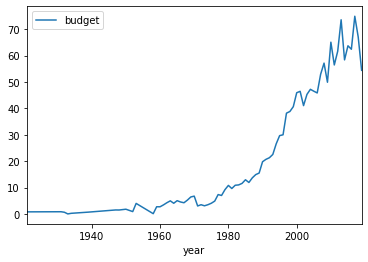

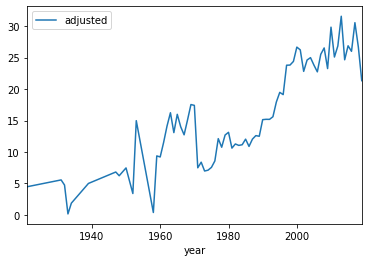

In [141]:
df_budget_adjusted.head()
x = df_budget_adjusted.sort_values(by='year')[['year','budget']]
x = x.groupby(['year']).mean().reindex()
x.plot(kind='line')

x = df_budget_adjusted.sort_values(by='year')[['year','adjusted']]
x = x.groupby(['year']).mean().reindex()
x.plot(kind='line')

# The Pre-Oscar Score

Each movie, based on its cast, director, writer, editor etc., will be scored based on what awards and nominations. This scoring will include the 2019 movies. 

In [147]:
def pre_oscar_score(df_movies, categories, movie_dict, df_indi_score, df_oscar_score):
    """takes a year and title of a film and gives it a totla score based on Oscar records of actors, 
    directors and editorial crew
    """
    if categories == 'all':
                categories = pickle.load(open("my_data_3/main_categories","rb"))
    
    df_movies['prescore'] = 0 # initialize all socre to zero
    df_movies['postscore'] = 0
            
    for row in df_movies.iterrows(): # go through each movie
        idx = row[0]
        if idx%50==0:
            clear_output()
            print(f'{idx}of {len(df_movies)}')
        title = row[1].title
        year = row[1].year
        if (title,year) in movie_dict:
            movie = movie_dict[title,year]
        else: 
            continue

        # get all_members from the infobox information in movie_dict
        score = 0
        checked_members = [] # to prevent double counting if any personnel is repeated (example: director and writer)
        
        # aggregate accross categories and members
        for field in movie:
            if type(movie[field])==list:
                for member in movie[field]:
                    if member in checked_members:
                        continue
                    checked_members.append(member)
                    for category in categories:
                        score = score + df_indi_score[(df_indi_score.year <year) & (df_indi_score.name == member)& 
                                                      (df_indi_score.category == category)].score.sum()
        
        df_movies.loc[idx,'prescore'] = score
        
        score = df_oscar_score[df_oscar_score.film == title].score.sum()
        df_movies.loc[idx,'postscore'] = score
    
    return df_movies

In [163]:
df_movies.tail()

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,running_time,prescore,postscore
5869,tt10039344,countdown,2019,3613.0,5.4,6.5,35.5,8.0,90.0,0.0,0.0
5874,tt5113040,the secret life of pets 2,2019,31612.0,6.5,80.0,433.0,13.0,86.0,0.0,0.0
5875,tt6772804,escape plan: the extractors,2019,7317.0,4.4,3.6,1.8,10.0,88.0,0.0,0.0
5878,tt6189022,angel has fallen,2019,23539.0,6.6,40.0,133.4,8.0,121.0,0.0,0.0
5879,tt1606375,downton abbey,2019,148371.0,8.7,20.0,188.7,7.0,122.0,0.0,0.0


In [148]:
df_with_prescore = pre_oscar_score(df_movies, 'all', movie_dict, df_indi_score, df_oscar_score)

5850of 4733


In [158]:
df_with_prescore.query("title=='a beautiful day in the neighborhood'")

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,running_time,prescore,postscore
5691,tt3224458,a beautiful day in the neighborhood,2019,7422.0,7.9,25.0,46.0,4.0,107.0,0.0,0.0


In [512]:
df_with_prescore.loc[4919,'budget']=35.0
df_with_prescore.sort_values(by='budget', ascending=False).head()
df_movies_with_score = df_with_prescore
df_movies_with_score.to_csv('my_data_3/df_movies_score.csv')

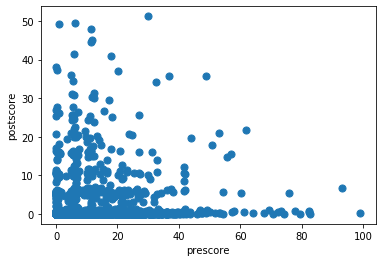

In [173]:
df_with_prescore.plot.scatter(x='prescore',y='postscore', s= 50)

# Exploratory Data Visualization

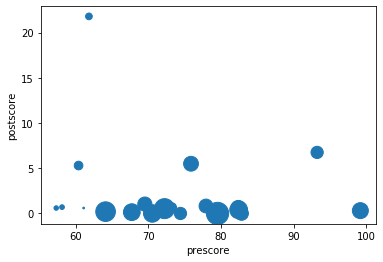

In [178]:
df_with_prescore.sort_values(by = ['prescore', 
                                   'postscore']).tail(20).plot.scatter(x = 'prescore', 
                                                    y = 'postscore', s = df_with_prescore.budget)

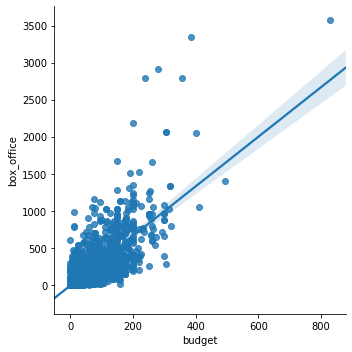

In [514]:
sns.lmplot(x= 'budget', y='box_office', data=df_movies_with_score)

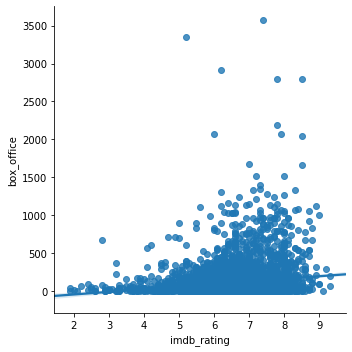

In [515]:
sns.lmplot(x= 'imdb_rating', y='box_office', data=df_movies_with_score)

In [184]:
df_super_awards.head()

,title,year,imdbID,picture,direction,performance,writing,technical,art,music
0,johnny handsome,1989,tt0097626,O,O,O,O,O,O,O
1,extreme prejudice,1987,tt0092997,O,O,O,O,O,O,O
2,x-men,2000,tt0120903,O,O,O,O,O,O,O
3,national lampoon's animal house,1978,tt0077975,O,O,O,O,O,O,O
4,the impossible,2012,tt1649419,O,O,N,O,O,O,O


In [185]:
df_with_prescore.head()

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,running_time,prescore,postscore
0,tt0097626,johnny handsome,1989,8324.0,6.2,20.0,7.24,7.0,96.0,0.400,0.0
1,tt0092997,extreme prejudice,1987,5649.0,6.7,22.0,11.31,3.0,104.0,5.375,0.0
3,tt0120903,x-men,2000,545484.0,7.4,75.0,296.30,10.0,104.0,5.775,0.0
5,tt0077975,national lampoon's animal house,1978,106182.0,7.5,3.0,141.60,6.0,109.0,6.000,0.0
8,tt1649419,the impossible,2012,182949.0,7.6,45.0,198.10,3.0,113.0,0.200,0.2


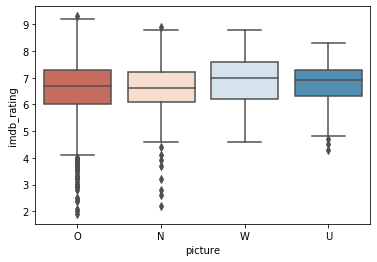

In [196]:
df = df_with_prescore.join(df_super_awards.picture).dropna()
df.shape
sns.boxplot(x='picture', y='imdb_rating', data=df, palette='RdBu')

In [192]:
df.head()

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,running_time,prescore,postscore,picture
0,tt0097626,johnny handsome,1989,8324.0,6.2,20.0,7.24,7.0,96.0,0.400,0.0,O
1,tt0092997,extreme prejudice,1987,5649.0,6.7,22.0,11.31,3.0,104.0,5.375,0.0,O
3,tt0120903,x-men,2000,545484.0,7.4,75.0,296.30,10.0,104.0,5.775,0.0,O
5,tt0077975,national lampoon's animal house,1978,106182.0,7.5,3.0,141.60,6.0,109.0,6.000,0.0,O
8,tt1649419,the impossible,2012,182949.0,7.6,45.0,198.10,3.0,113.0,0.200,0.2,O
